In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import os
import nltk
from nltk.corpus import stopwords
from google.colab import drive

# Load dataset
drive.mount('/content/drive')

#file path
file_path = '/content/drive/My Drive/Colab dataset/fake reviews dataset.csv'

# read csv file dataset
df = pd.read_csv(file_path)
# Preprocess text (Lowercase, remove punctuation)
df['text'] = df['text_'].str.lower().str.replace(r'[^\w\s]', '', regex=True)

Mounted at /content/drive


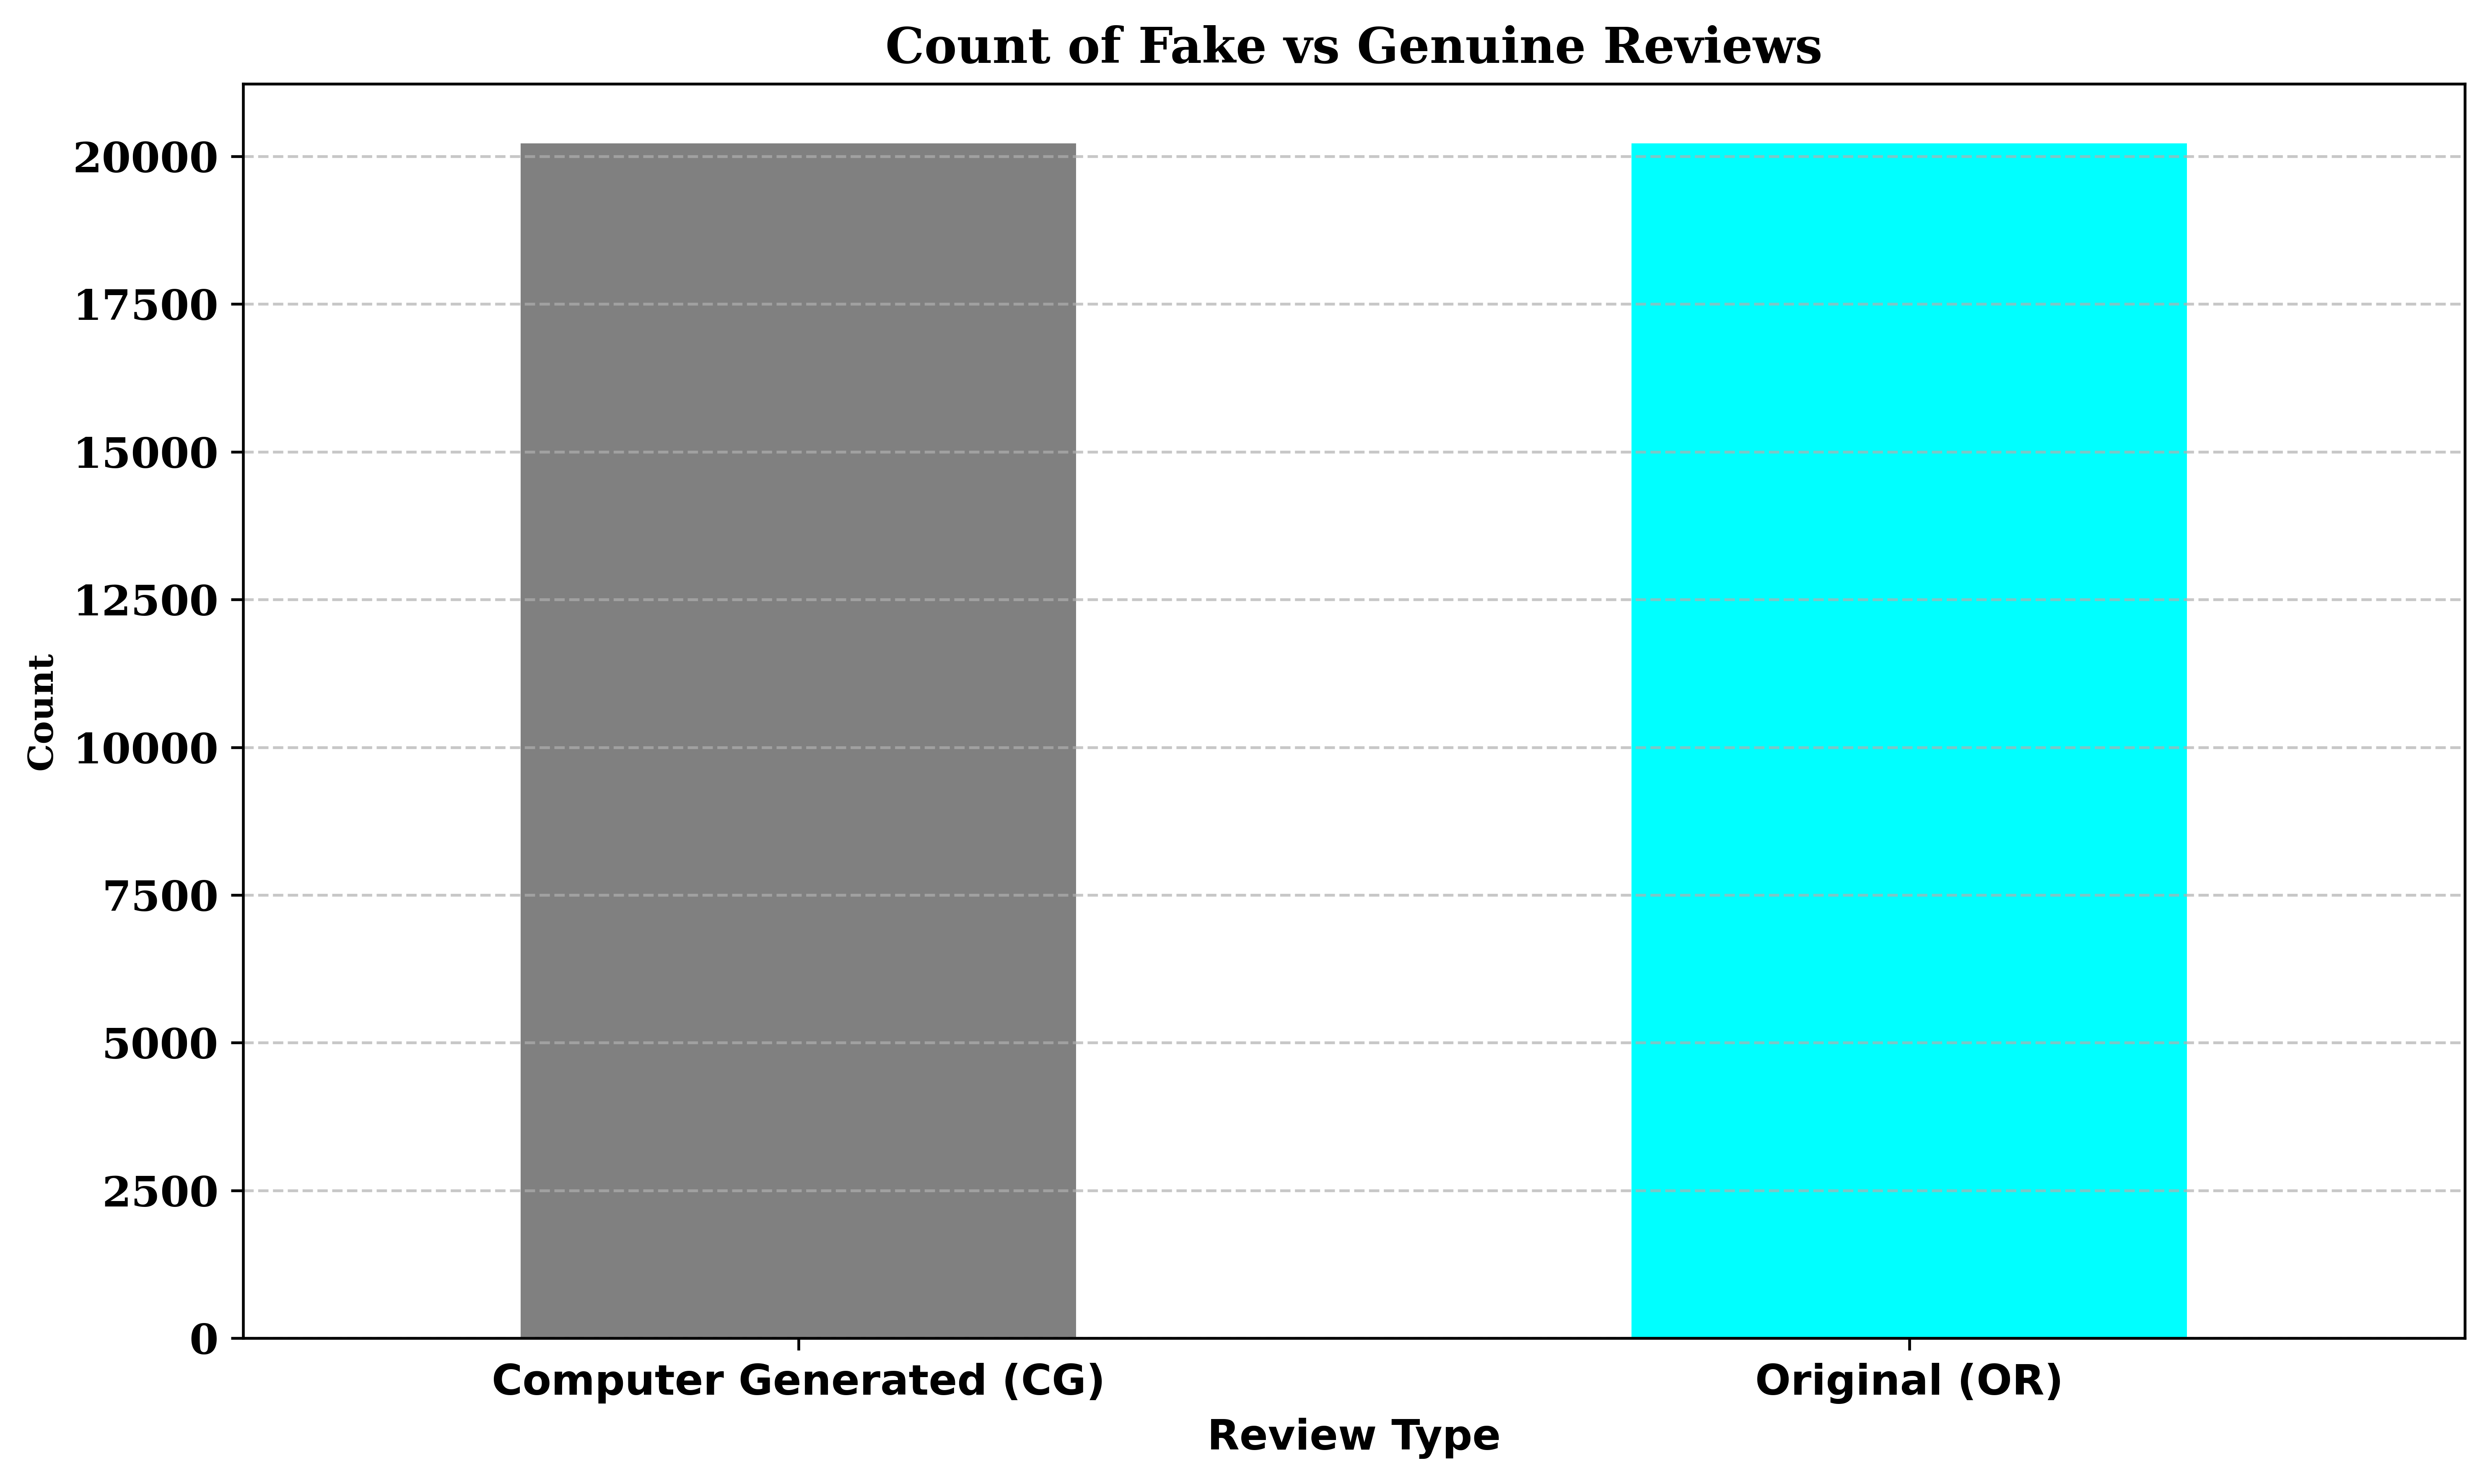

In [ ]:
plt.figure(figsize=(10, 6), dpi=600)
ax = df['label'].value_counts().plot(kind='bar', color=['gray', 'cyan'])

plt.title('Count of Fake vs Genuine Reviews', fontdict={'fontsize': 14,'fontweight': 'bold', 'family': 'serif'})

plt.xlabel('Review Type', fontdict={'fontsize': 12,'fontweight': 'bold'})
plt.ylabel('Count', fontdict={'fontweight': 'bold', 'family': 'serif'})

ax.set_xticklabels(['Computer Generated (CG)','Original (OR)'], fontdict={'fontsize': 12, 'fontweight': 'bold'}, rotation=0,ha='center')

plt.yticks(fontsize=12, fontweight='bold', family='serif')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



## SOGCO and CNN

### Loading and Preprocessing Data & Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Concatenate
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import nltk
import string

# Load NLTK resources
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Load dataset
file_path = '/content/drive/My Drive/Colab dataset/fake reviews dataset.csv'
df = pd.read_csv(file_path)

# Function to preprocess text
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    filtered_words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(filtered_words)


# Preprocess the review texts
df['processed_text'] = df['text_'].apply(preprocess_text)
y_feature = df['rating'].values.reshape(-1, 1)
y = df['label'].values

# Tokenization and padding
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['processed_text'])
sequences = tokenizer.texts_to_sequences(df['processed_text'])
padded_sequences = pad_sequences(sequences, maxlen=900)
# Label encoding
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y)
binary_labels = encoded_labels


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Features Extraction

In [ ]:
import numpy as np
from gensim.models import Word2Vec

# Prepare the data
sentences = [text.split() for text in df['processed_text']]

word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

def get_average_word2vec(words, model, vector_size=100):
    feature_vec = np.zeros((vector_size,), dtype="float32")
    num_words = 0
    for word in words:
        if word in model.wv.key_to_index:
            num_words += 1
            feature_vec = np.add(feature_vec, model.wv[word])
    if num_words > 0:
        feature_vec = np.divide(feature_vec, num_words)
    return feature_vec

all_features = np.array([get_average_word2vec(text.split(), word2vec_model, vector_size=100) for text in df['processed_text']])
all_features = np.concatenate([all_features, y_feature], axis=1)


### Define Model Creation Function

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np

def create_model(num_selected_features):
    # Text input
    text_input = Input(shape=(900,), name='text_input')
    embedding_layer = Embedding(input_dim=10000, output_dim=128)(text_input)
    conv_layer = Conv1D(filters=64, kernel_size=(5,), activation='relu')(embedding_layer)
    pooling_layer = MaxPooling1D(pool_size=2)(conv_layer)
    flatten_layer = Flatten()(pooling_layer)

    # Feature input
    features_input = Input(shape=(num_selected_features,), name='features_input')

    # Concatenate text and features
    concatenated = Concatenate()([flatten_layer, features_input])

    # Dense layers
    dense_layer_1 = Dense(64, activation='relu')(concatenated)
    dense_layer_2 = Dense(32, activation='relu')(dense_layer_1)
    output_layer = Dense(1, activation='sigmoid')(dense_layer_2)

    # Create model
    model = Model(inputs=[text_input, features_input], outputs=output_layer)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return model


### Training through K-Fold

In [ ]:
def evaluate_model_kfold(selected_features, k=3):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []

    for train_index, val_index in kf.split(padded_sequences):
        x_train_sequences, x_val_sequences = padded_sequences[train_index], padded_sequences[val_index]
        x_train_, x_val_ = all_features[train_index], all_features[val_index]
        y_train, y_val = binary_labels[train_index], binary_labels[val_index]

        x_train_selected = x_train_[:, selected_features]
        x_val_selected = x_val_[:, selected_features]

        model = create_model(len(selected_features))

        # Train the model
        model.fit(
            [x_train_sequences, x_train_selected],
            y_train,
            epochs=3,
            batch_size=32,
            verbose=0
        )

        y_pred_probs = model.predict([x_val_sequences, x_val_selected])
        y_pred = (y_pred_probs > 0.5).astype(int)
        y_true = y_val

        accuracies.append(accuracy_score(y_true, y_pred))

    return np.mean(accuracies)


###SOGCO Implementation

In [ ]:
import numpy as np
import tracemalloc

def sogco_algorithm(population_size, generations, base_mutation_rate, all_features):
    _features = all_features.shape[1]

    # Initialize sub-population for features
    feature_selection_pop = [np.random.choice([0, 1], _features).tolist() for _ in range(population_size)]

    best_features = []
    best_fitness = 0

    def create_individual(features):
        return {
            'features': features
        }


    def calculate_diversity(population):
        return np.var(population)

    # Cooperative Learning
    def cooperative_learning(population, top_n=3):
        top_individuals = sorted(population, key=lambda ind: ind['fitness'], reverse=True)[:top_n]

        cooperative_features = np.mean([ind['features'] for ind in top_individuals], axis=0)
        cooperative_features = np.round(cooperative_features).astype(int).tolist()

        return cooperative_features

    # Genetic Algorithm loop
    for generation in range(generations):
        fitness_scores = []
        print(f"Generation {generation+1}/{generations}")

        population = []

        for i in range(population_size):
            individual = create_individual(feature_selection_pop[i])
            print(f"Evaluating individual {i+1}/{population_size}")

            # Evaluate the individual (assuming evaluate_model_kfold is defined elsewhere)
            fitness = evaluate_model_kfold(individual['features'], k=3)
            individual['fitness'] = fitness
            population.append(individual)
            fitness_scores.append(fitness)
            print(f"Individual {i+1} - Fitness: {fitness:.4f}")

        if not fitness_scores:
            continue

        best_index = np.argmax(fitness_scores)
        best_fitness = fitness_scores[best_index]
        best_features = feature_selection_pop[best_index]
        print(f"New best fitness found: {best_fitness:.4f}")

        feature_selection_diversity = calculate_diversity([tuple(f['features']) for f in population])

        # Self-organize the mutation rate to maintain diversity
        diversity_threshold = 0.1
        if feature_selection_diversity < diversity_threshold:
            mutation_rate = base_mutation_rate * 1.5
        else:
            mutation_rate = base_mutation_rate

        selected_indices = np.argsort(fitness_scores)[-population_size // 2:]
        selected_feature_selection = [feature_selection_pop[i] for i in selected_indices]

        new_feature_selection_pop = selected_feature_selection.copy()

        while len(new_feature_selection_pop) < population_size:
            parent1, parent2 = np.random.choice(len(selected_feature_selection), 2)

            # Crossover for feature selection
            new_features = [
                np.random.choice([selected_feature_selection[parent1][i], selected_feature_selection[parent2][i]])
                for i in range(_features)
            ]
            new_feature_selection_pop.append(new_features)

            # Mutation
            if np.random.rand() < mutation_rate:
                mutation_index = np.random.choice(len(new_feature_selection_pop))
                new_feature_selection_pop[mutation_index] = np.random.choice([0, 1], _features).tolist()

        # Apply cooperative learning
        cooperative_features = cooperative_learning(population)
        new_feature_selection_pop.append(cooperative_features)

        feature_selection_pop = new_feature_selection_pop

    return best_features, best_fitness

# Start tracking memory usage
tracemalloc.start()

population_size = 5
generations = 5
base_mutation_rate = 0.1

best_features, best_fitness = sogco_algorithm(population_size, generations, base_mutation_rate, all_features)

# Calculating the number of selected features
selected_features_count = sum(best_features)

print(f"Total number of selected features: {selected_features_count}")

#print memory stats
current, peak = tracemalloc.get_traced_memory()
print(f"Memory Usage: Current = {current / 1024**2:.2f} MB; Peak = {peak / 1024**2:.2f} MB")

# Stop tracemalloc
tracemalloc.stop()


Generation 1/5
Evaluating individual 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Individual 1 - Fitness: 0.8907
Evaluating individual 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Individual 2 - Fitness: 0.8951
Evaluating individual 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Individual 3 - Fitness: 0.8927
Evaluating individual 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Individual 4 - Fitness: 0.8948
Evaluating individual 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Individual 5 - Fitness: 0.8922
New best fitness found: 0.8951
Generation 2/5
Evaluating individual 1/5
422/422 ━━━━━

### Training Final Model and Evaluation






In [ ]:
_best_feature_selection = best_features

selected_features = all_features[:, _best_feature_selection]

# Train the final model with selected features
final_model = create_model(len(_best_feature_selection))
history = final_model.fit(
    [padded_sequences, selected_features],
    binary_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

# Evaluate the final model
selected_all_features_eval = all_features[:, _best_feature_selection]
final_evaluation = final_model.evaluate([padded_sequences, selected_all_features_eval], binary_labels)
print(f"Final Model evaluation - Loss: {final_evaluation[0]}, Accuracy: {final_evaluation[1]}")


Epoch 1/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7611 - loss: 0.4617 - val_accuracy: 0.8064 - val_loss: 0.4246
Epoch 2/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9254 - loss: 0.1870 - val_accuracy: 0.7942 - val_loss: 0.5372
Epoch 3/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9610 - loss: 0.1035 - val_accuracy: 0.8161 - val_loss: 0.5190
Epoch 4/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9780 - loss: 0.0607 - val_accuracy: 0.8056 - val_loss: 0.7018
Epoch 5/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9877 - loss: 0.0342 - val_accuracy: 0.7973 - val_loss: 0.7817
Epoch 6/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9897 - loss: 0.0283 - val_accuracy: 0.8081 - val_loss: 1.0208
Epoch 7/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9951 - loss: 0.0145 - val_accuracy: 0.8123 - val_loss: 1.1067
Epoch 8/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9963 - loss: 0.0119 - val_acc

### Generating Evaluation Metrics and Plots

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
True Negatives (TN): 19298
False Positives (FP): 918
False Negatives (FN): 601
True Positives (TP): 19615


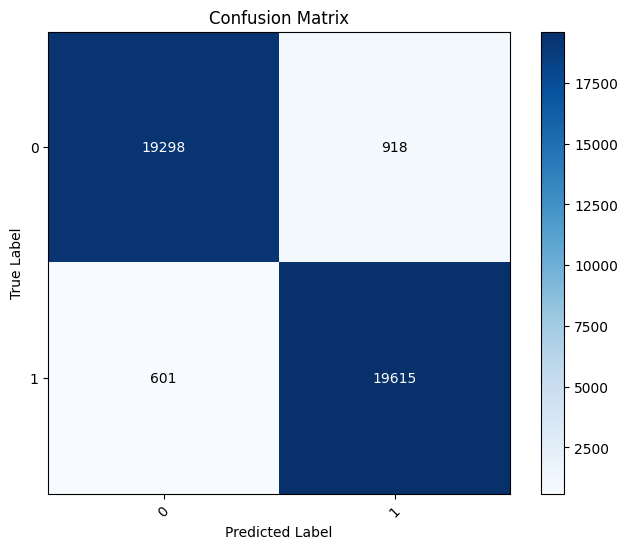

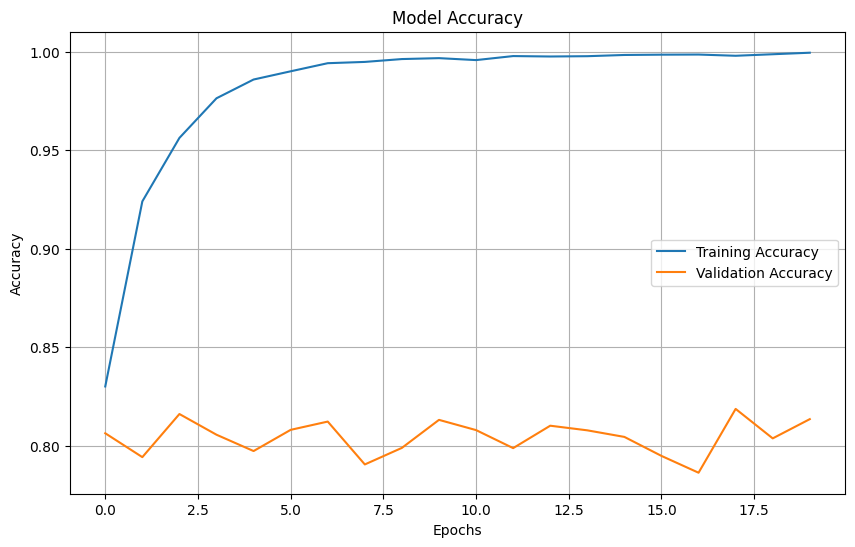

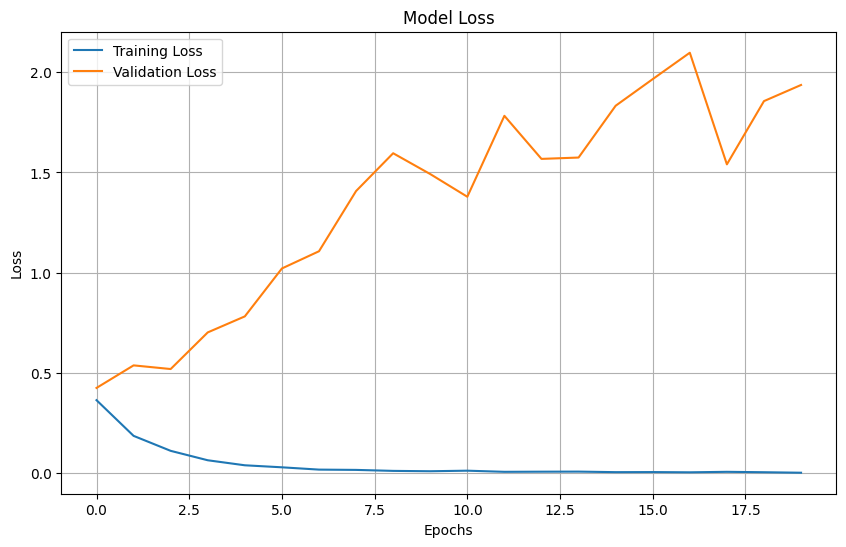

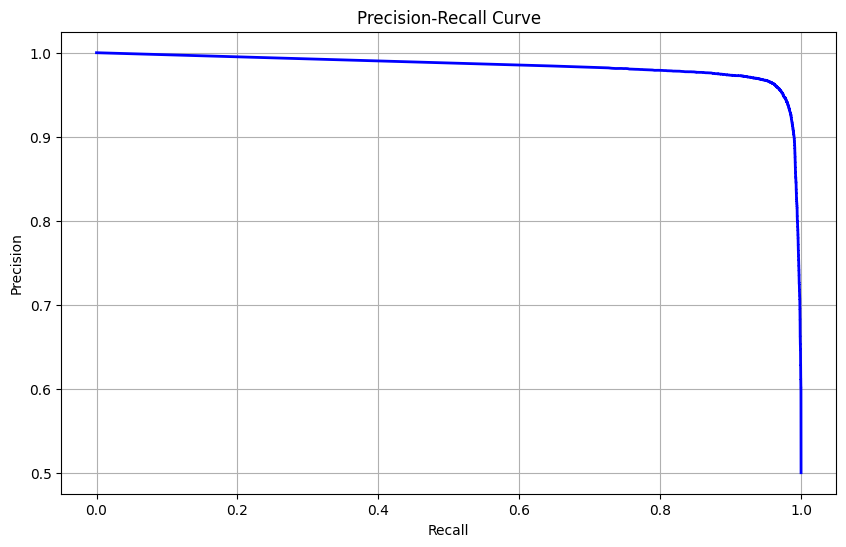

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np

best_feature_selection_ = best_features

selected__features = all_features[:, best_feature_selection_]

best_model = final_model
y_pred_probs = best_model.predict([padded_sequences, selected__features]).flatten()
y_pred = (y_pred_probs >= 0.5).astype(int)
y_true = binary_labels

cm = confusion_matrix(y_true, y_pred)

# Extracting values from confusion matrix
TN, FP, FN, TP = cm.ravel()

print(f'True Negatives (TN): {TN}')
print(f'False Positives (FP): {FP}')
print(f'False Negatives (FN): {FN}')
print(f'True Positives (TP): {TP}')

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ['0', '1'], rotation=45)
plt.yticks(tick_marks, ['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center',
                 color='white' if cm[i, j] > cm.max() / 2. else 'black')
plt.grid(False)
plt.show()

# Plot Accuracy over Epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss over Epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


Epoch 1/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.5012 - loss: 8.1793 - val_accuracy: 0.5033 - val_loss: 3.3712 - learning_rate: 2.5000e-04
Epoch 2/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5014 - loss: 2.9661 - val_accuracy: 0.4966 - val_loss: 1.7685 - learning_rate: 2.5000e-04
Epoch 3/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6734 - loss: 1.4849 - val_accuracy: 0.7402 - val_loss: 0.9578 - learning_rate: 2.5000e-04
Epoch 4/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8778 - loss: 0.6819 - val_accuracy: 0.9174 - val_loss: 0.4288 - learning_rate: 2.5000e-04
Epoch 5/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8989 - loss: 0.4150 - val_accuracy: 0.9287 - val_loss: 0.2728 - learning_rate: 2.5000e-04
Epoch 6/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9173 - loss: 0.2783 - val_accuracy: 0.9299 - val_loss: 0.2377 - learning_rate: 2.5000e-04
Epoch 7/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - ac

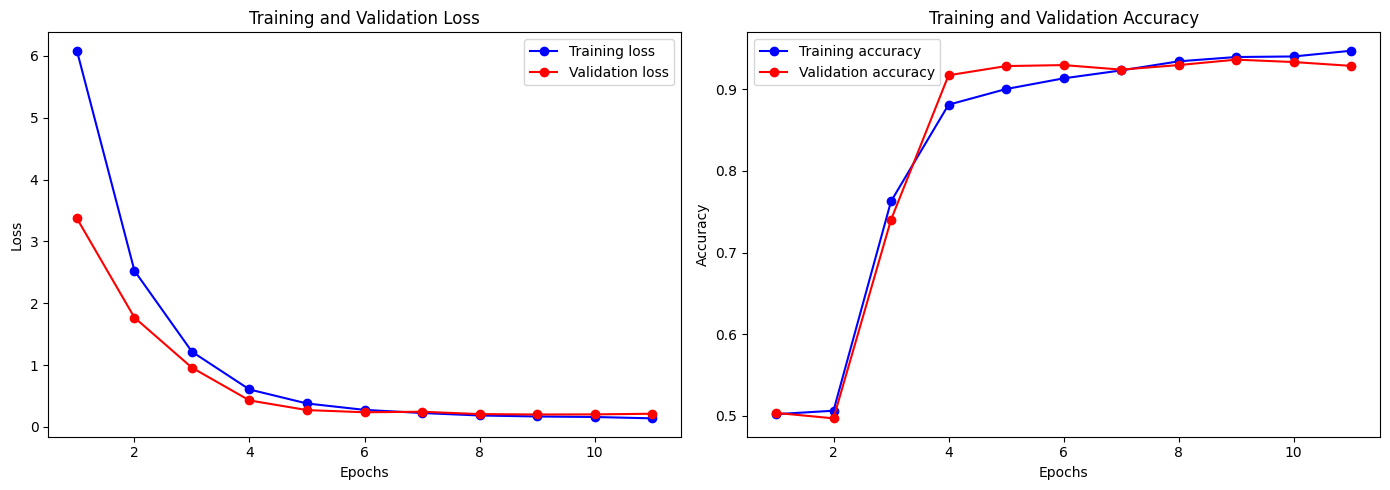

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2

# Load dataset
df = pd.read_csv(file_path)

# Preprocessing
X_text = df['text_'].astype(str).values
y = df['label'].values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_text)
X_sequences = tokenizer.texts_to_sequences(X_text)
X_padded = pad_sequences(X_sequences, maxlen=900)

# Split text and features into training and validation sets
X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_padded, binary_labels, test_size=0.2, random_state=42
)
X_train_features, X_val_features, y_train, y_val = train_test_split(
    all_features, binary_labels, test_size=0.2, random_state=42
)
# Function to build the final model with optimizations using the selected features
def build_final_model_with_optimizations(num_selected_features):
    # Text input
    text_input = Input(shape=(900,), name='text_input')
    embedding_layer = Embedding(input_dim=10000, output_dim=128)(text_input)
    conv_layer = Conv1D(filters=64, kernel_size=(5,), activation='relu')(embedding_layer)
    pooling_layer = MaxPooling1D(pool_size=2)(conv_layer)
    dropout_layer_1 = Dropout(0.6)(pooling_layer)
    flatten_layer = Flatten()(dropout_layer_1)

    # Features input, using selected features only
    features_input = Input(shape=(num_selected_features,), name='features_input')
    concatenated = Concatenate()([flatten_layer, features_input])

    # Dense layers with regularization and dropout
    dense_layer_1 = Dense(64, activation='relu', kernel_regularizer=l2(0.035))(concatenated)
    batch_norm_layer_1 = BatchNormalization()(dense_layer_1)
    dropout_layer_2 = Dropout(0.6)(batch_norm_layer_1)

    dense_layer_2 = Dense(64, activation='relu', kernel_regularizer=l2(0.035))(dropout_layer_2)
    batch_norm_layer_2 = BatchNormalization()(dense_layer_2)
    dropout_layer_3 = Dropout(0.6)(batch_norm_layer_2)

    dense_layer_3 = Dense(64, activation='relu', kernel_regularizer=l2(0.035))(dropout_layer_3)
    batch_norm_layer_3 = BatchNormalization()(dense_layer_3)
    dropout_layer_4 = Dropout(0.6)(batch_norm_layer_3)

    output_layer = Dense(1, activation='sigmoid')(dropout_layer_4)

    # Create model
    model = Model(inputs=[text_input, features_input], outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.00025), loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001)

    return model, [early_stopping, lr_reduction]

_best_feature_selection = best_features
valid_indices = [i for i, val in enumerate(_best_feature_selection) if val == 1]

selected_train_features = X_train_features[:, valid_indices]
selected_val_features = X_val_features[:, valid_indices]

final_model, callbacks = build_final_model_with_optimizations(len(valid_indices))

history = final_model.fit(
    [X_train_text, selected_train_features],
    y_train,
    epochs=20,
    batch_size=64,
    validation_data=([X_val_text, selected_val_features], y_val),
    callbacks=callbacks,
    verbose=1
)


final_evaluation = final_model.evaluate([X_val_text, selected_val_features], y_val)
print(f"Final Model evaluation - Loss: {final_evaluation[0]}, Accuracy: {final_evaluation[1]}")

# Plot training & validation loss and accuracy
def plot_metrics(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Show plots
    plt.tight_layout()
    plt.show()
plot_metrics(history)


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
True Negatives (TN): 3718
False Positives (FP): 306
False Negatives (FN): 230
True Positives (TP): 3832


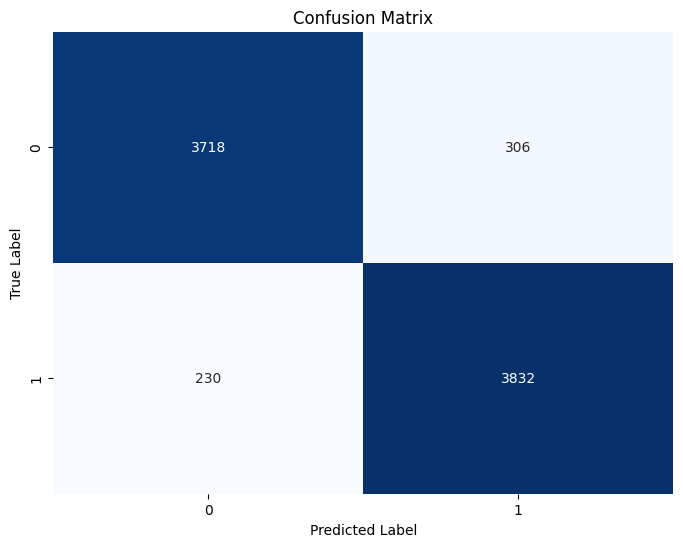

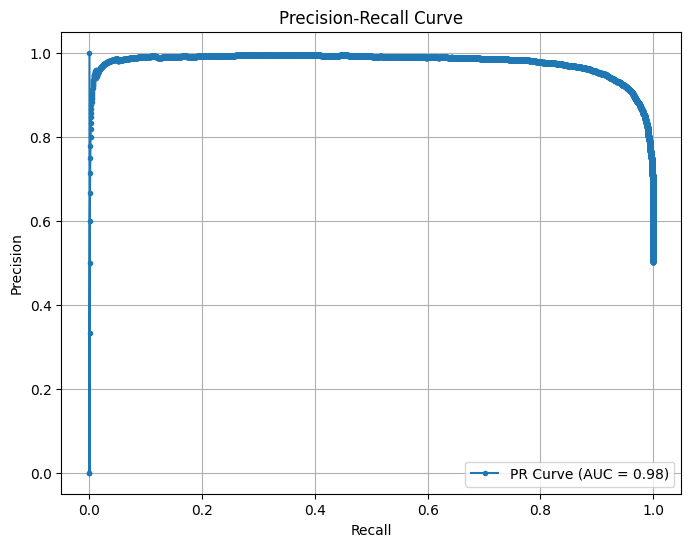

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc
import seaborn as sns

y_pred = final_model.predict([X_val_text, selected_val_features])
y_pred_classes = (y_pred > 0.5).astype("int32")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)


# Extracting values from confusion matrix
TN, FP, FN, TP = conf_matrix.ravel()

print(f'True Negatives (TN): {TN}')
print(f'False Positives (FP): {FP}')
print(f'False Negatives (FN): {FN}')
print(f'True Positives (TP): {TP}')


# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_pred)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2

# Load dataset
df = pd.read_csv(file_path)

# Preprocessing
X_text = df['text_'].astype(str).values
y = df['label'].values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_text)
X_sequences = tokenizer.texts_to_sequences(X_text)
X_padded = pad_sequences(X_sequences, maxlen=900)


_best_feature_selection = best_features
valid_indices = [i for i, val in enumerate(_best_feature_selection) if val == 1]

# Initialize KFold with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store the results for each fold
fold_accuracy = []

# Function to build the final model with optimizations using the selected features
def build_final_model_with_optimizations(num_selected_features):
    # Text input
    text_input = Input(shape=(900,), name='text_input')
    embedding_layer = Embedding(input_dim=10000, output_dim=128)(text_input)
    conv_layer = Conv1D(filters=64, kernel_size=(5,), activation='relu')(embedding_layer)
    pooling_layer = MaxPooling1D(pool_size=2)(conv_layer)
    dropout_layer_1 = Dropout(0.6)(pooling_layer)
    flatten_layer = Flatten()(dropout_layer_1)

    # Features input, using selected features only
    features_input = Input(shape=(num_selected_features,), name='features_input')
    concatenated = Concatenate()([flatten_layer, features_input])

    # Dense layers with regularization and dropout
    dense_layer_1 = Dense(64, activation='relu', kernel_regularizer=l2(0.035))(concatenated)
    batch_norm_layer_1 = BatchNormalization()(dense_layer_1)
    dropout_layer_2 = Dropout(0.6)(batch_norm_layer_1)

    dense_layer_2 = Dense(64, activation='relu', kernel_regularizer=l2(0.035))(dropout_layer_2)
    batch_norm_layer_2 = BatchNormalization()(dense_layer_2)
    dropout_layer_3 = Dropout(0.6)(batch_norm_layer_2)

    dense_layer_3 = Dense(64, activation='relu', kernel_regularizer=l2(0.035))(dropout_layer_3)
    batch_norm_layer_3 = BatchNormalization()(dense_layer_3)
    dropout_layer_4 = Dropout(0.6)(batch_norm_layer_3)

    output_layer = Dense(1, activation='sigmoid')(dropout_layer_4)

    # Create model
    model = Model(inputs=[text_input, features_input], outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.00025), loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks for early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001)

    return model, [early_stopping, lr_reduction]

# K-Fold Cross Validation
for fold, (train_index, val_index) in enumerate(kf.split(X_padded, y_encoded)):
    print(f"Training on Fold {fold+1}...")

    X_train_text_fold, X_val_text_fold = X_padded[train_index], X_padded[val_index]
    y_train_fold, y_val_fold = y_encoded[train_index], y_encoded[val_index]

    X_train_features_fold, X_val_features_fold = all_features[train_index], all_features[val_index]

    # Select only the features indicated by the valid indices
    selected_train_features_fold = X_train_features_fold[:, valid_indices]
    selected_val_features_fold = X_val_features_fold[:, valid_indices]

    # Build the model for this fold
    final_model, callbacks = build_final_model_with_optimizations(len(valid_indices))

    # Train the model
    history = final_model.fit(
        [X_train_text_fold, selected_train_features_fold],
        y_train_fold,
        epochs=20,
        batch_size=64,
        validation_data=([X_val_text_fold, selected_val_features_fold], y_val_fold),
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate the model on the validation set
    final_evaluation = final_model.evaluate([X_val_text_fold, selected_val_features_fold], y_val_fold)
    print(f"Fold {fold+1} - Loss: {final_evaluation[0]}, Accuracy: {final_evaluation[1]}")

    fold_accuracy.append(final_evaluation[1])

# Calculate the average results across all folds
average_accuracy = np.mean(fold_accuracy)

print(f"Average Cross-Validation Accuracy: {average_accuracy}")


Training on Fold 1...
Epoch 1/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.5040 - loss: 8.2901 - val_accuracy: 0.5451 - val_loss: 3.5121 - learning_rate: 2.5000e-04
Epoch 2/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5723 - loss: 3.0386 - val_accuracy: 0.8527 - val_loss: 1.4712 - learning_rate: 2.5000e-04
Epoch 3/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8645 - loss: 1.2364 - val_accuracy: 0.8548 - val_loss: 0.7729 - learning_rate: 2.5000e-04
Epoch 4/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9044 - loss: 0.6001 - val_accuracy: 0.7971 - val_loss: 0.6062 - learning_rate: 2.5000e-04
Epoch 5/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9187 - loss: 0.3414 - val_accuracy: 0.6053 - val_loss: 1.3040 - learning_rate: 2.5000e-04
Epoch 6/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9238 - loss: 0.2555 - val_accuracy: 0.8707 - val_loss: 0.3787 - learning_rate: 1.2500e-04
Epoch 7/20
506/506 ━━━━━━━━━━━━━━━━

## ACO with CNN

In [ ]:
import numpy as np
import re
import random
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import tracemalloc

def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    df = df.dropna(subset=['text_', 'label'])
    df['text'] = df['text_'].str.lower().apply(lambda x: re.sub(r'[^\w\s]', '', x))
    return df

# Apply TF-IDF vectorization
def vectorize_text(df):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform(df['text']).toarray()
    return X, vectorizer

def encode_labels(df):
    le = LabelEncoder()
    y = le.fit_transform(df['label'])
    return y, le

# ACO for feature selection
class AntColonyOptimizer:
    def __init__(self, n_ants=5, n_iterations=10, decay=0.6, alpha=0.5, beta=0.5):
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta

    def fit(self, X, y):
        n_features = X.shape[1]
        pheromone = np.ones((n_features,))
        best_features = None
        best_score = -np.inf

        for iteration in range(self.n_iterations):
            all_solutions = []
            all_scores = []

            for ant in range(self.n_ants):
                feature_indices = np.arange(n_features)
                probs = pheromone ** self.alpha
                probs /= probs.sum()
                selected = np.random.choice(feature_indices, size=int(n_features*0.5), replace=False, p=probs)

                score = self.evaluate_solution(X[:, selected], y)
                all_solutions.append(selected)
                all_scores.append(score)

                if score > best_score:
                    best_score = score
                    best_features = selected

            pheromone = (1 - self.decay) * pheromone
            for i, score in enumerate(all_scores):
                pheromone[all_solutions[i]] += score

        return best_features

    def evaluate_solution(self, X, y):
        classifier = KNeighborsClassifier()
        score = cross_val_score(classifier, X, y, cv=3, scoring='accuracy').mean()
        return score

# Main execution for ACO
def main_():
    filepath = '/content/drive/My Drive/Colab dataset/fake reviews dataset.csv'
    df = load_and_preprocess_data(filepath)
    X, vectorizer = vectorize_text(df)
    y, le = encode_labels(df)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    tracemalloc.start()

    aco = AntColonyOptimizer(n_ants=5, n_iterations=10)
    selected_features = aco.fit(X_train, y_train)

    # Stop tracking memory usage and get memory info
    current, peak = tracemalloc.get_traced_memory()
    print(f"ACO Memory Usage: Current = {current / 1024**2:.2f} MB; Peak = {peak / 1024**2:.2f} MB")

    tracemalloc.stop()

    num_selected_features = len(selected_features)
    print(f"Total number of selected features: {num_selected_features}")
    return X_train, X_test, y_train, y_test, selected_features

X_train, X_test, y_train, y_test, selected_features = main_()


ACO Memory Usage: Current = 0.18 MB; Peak = 348.12 MB
Total number of selected features: 500


Epoch 1/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6391 - loss: 0.7061 - val_accuracy: 0.6829 - val_loss: 0.6654
Epoch 2/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6941 - loss: 0.6531 - val_accuracy: 0.7065 - val_loss: 0.6222
Epoch 3/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7065 - loss: 0.6175 - val_accuracy: 0.7108 - val_loss: 0.6047
Epoch 4/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7167 - loss: 0.6064 - val_accuracy: 0.7233 - val_loss: 0.5972
Epoch 5/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7195 - loss: 0.5948 - val_accuracy: 0.7276 - val_loss: 0.5845
Epoch 6/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7235 - loss: 0.5881 - val_accuracy: 0.7268 - val_loss: 0.5796
Epoch 7/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7188 - loss: 0.5910 - val_accuracy: 0.7248 - val_loss: 0.5811
Epoch 8/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7260 - loss: 0.5831 - val_accuracy: 0.

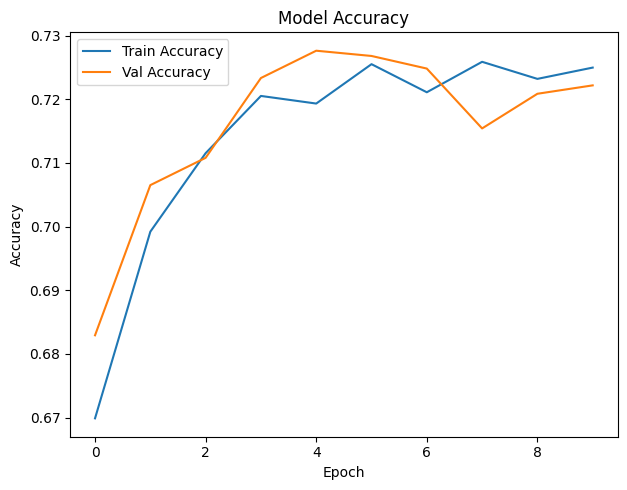

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# Build CNN model
def build_cnn_model(input_shape):
    model = Sequential([
        Conv1D(16, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(16, activation='relu', kernel_regularizer=l2(0.007)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train and evaluate CNN model
def train_and_evaluate_model(X_train, X_test, y_train, y_test, selected_features):
    input_shape = (len(selected_features), 1)
    X_train_selected = X_train[:, selected_features].reshape(-1, len(selected_features), 1)
    X_test_selected = X_test[:, selected_features].reshape(-1, len(selected_features), 1)

    model = build_cnn_model(input_shape)

    history = model.fit(
        X_train_selected, y_train,
        epochs=10,
        batch_size=64,
        validation_split=0.2,
    )

    evaluation = model.evaluate(X_test_selected, y_test)
    print(f"Loss: {evaluation[0]}, Accuracy: {evaluation[1]}")

    return model, history

# Main execution for CNN
def main_cnn(X_train, X_test, y_train, y_test, selected_features):
    model, history = train_and_evaluate_model(X_train, X_test, y_train, y_test, selected_features)

    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

main_cnn(X_train, X_test, y_train, y_test, selected_features)
